In [1]:
from datasets import DatasetDict, Dataset, ClassLabel, Sequence, Value, Features
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from time import localtime, strftime

In [2]:
CL = 5
splits = ["train", "val", "test"]
dfs = [pd.read_csv(f"../D0/{split}.csv") for split in ["train", "val", "test"]]

filtered_dfs = list(map(lambda df: df.groupby("Dialogue_ID").filter(lambda x: x["Utterance"].count() >= CL), dfs))

def process(df):
    rows = []
    for _, conversation in df.groupby("Dialogue_ID"):
        for i in range(len(conversation) - 5 + 1):
            window = conversation[i:i + 5]
            rows.append([window["Utterance"].tolist(), window["Speaker"].tolist(), window["Emotion"].iloc[-1]])

    return pd.DataFrame(rows, columns=["text", "speaker", "labels"])

processed_dfs = map(process, filtered_dfs)

dataset_map = map(lambda df: Dataset.from_pandas(df, features=Features({
    "text": Sequence(Value(dtype="string"), length=5),
    "speaker": Sequence(Value(dtype="string"), length=5),
    "labels": ClassLabel(names=["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]),
})), processed_dfs)

dataset = DatasetDict({s: df for s, df in zip(splits, dataset_map)})

In [3]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def preprocess_data(examples):
    convs = [
        tokenizer.apply_chat_template(
            [{"role": "system", "content": f"How does {examples['speaker'][x][-1]} feel at the end of the conversation?"}] + \
            [{"role": examples["speaker"][x][i], "content": examples["text"][x][i] + " "} for i in range(CL)], 
            tokenize=False)
        for x in range(len(examples["text"]))
    ]

    encoding = tokenizer(convs, max_length=288, truncation=True)

    return encoding


tokenized_dataset = dataset.map(preprocess_data, batched=True, batch_size=100000,)
                                # remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6221 [00:00<?, ? examples/s]


No chat template is defined for this tokenizer - using a default chat template that implements the ChatML format (without BOS/EOS tokens!). If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Map:   0%|          | 0/1577 [00:00<?, ? examples/s]

In [4]:
def get_model():
    return AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=7)

In [5]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics = {
        "WA": accuracy_score(labels, predictions).tolist(),
        "UWA": balanced_accuracy_score(labels, predictions).tolist(),
        "miF1": f1_score(labels, predictions, average="micro"),
        "maF1": f1_score(labels, predictions, average="macro"),
        "wtF1": f1_score(labels, predictions, average="weighted"),
    }

    return metrics

In [6]:
loss_fn = nn.CrossEntropyLoss(torch.Tensor(1/np.bincount(dataset["train"]["labels"])).to("cuda"))
# loss_fn = nn.CrossEntropyLoss()

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)

        loss = loss_fn(outputs["logits"], labels)
        return (loss, outputs) if return_outputs else loss

In [7]:
raise Exception

Exception: 

In [8]:
dir_name = strftime("%b-%d-%y-%H:%M:%S", localtime())
dir_name = "Jan-10-24-22:59:06"

training_args = TrainingArguments(
    output_dir=f"results/{dir_name}",
    logging_dir=f"results/{dir_name}/runs",
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=2e-6,
    max_grad_norm=1.0,
    num_train_epochs=40,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_strategy="epoch",
    report_to="none",
    save_strategy="epoch",
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    disable_tqdm=False
)

trainer = WeightedTrainer(
    model_init=get_model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train(resume_from_checkpoint=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3920 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.0048, 'learning_rate': 7.777777777777778e-07, 'epoch': 26.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4560647010803223, 'eval_WA': 0.5145772594752187, 'eval_UWA': 0.48186999407415937, 'eval_miF1': 0.5145772594752187, 'eval_maF1': 0.43993443706274926, 'eval_wtF1': 0.5352955802852443, 'eval_runtime': 1.756, 'eval_samples_per_second': 390.66, 'eval_steps_per_second': 6.264, 'epoch': 26.0}
{'loss': 0.9904, 'learning_rate': 7.222222222222221e-07, 'epoch': 27.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.457006812095642, 'eval_WA': 0.5029154518950437, 'eval_UWA': 0.4774189894817713, 'eval_miF1': 0.5029154518950437, 'eval_maF1': 0.4331592709836768, 'eval_wtF1': 0.5265783261562637, 'eval_runtime': 1.7622, 'eval_samples_per_second': 389.288, 'eval_steps_per_second': 6.242, 'epoch': 27.0}
{'loss': 0.9827, 'learning_rate': 6.666666666666666e-07, 'epoch': 28.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4645681381225586, 'eval_WA': 0.5306122448979592, 'eval_UWA': 0.4927722022710309, 'eval_miF1': 0.5306122448979592, 'eval_maF1': 0.4515218557995925, 'eval_wtF1': 0.546303925877484, 'eval_runtime': 1.7579, 'eval_samples_per_second': 390.246, 'eval_steps_per_second': 6.258, 'epoch': 28.0}
{'loss': 0.9677, 'learning_rate': 6.111111111111112e-07, 'epoch': 29.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4746530055999756, 'eval_WA': 0.5364431486880467, 'eval_UWA': 0.47575514905445376, 'eval_miF1': 0.5364431486880467, 'eval_maF1': 0.4454107580766414, 'eval_wtF1': 0.5539541626981881, 'eval_runtime': 1.7566, 'eval_samples_per_second': 390.52, 'eval_steps_per_second': 6.262, 'epoch': 29.0}
{'loss': 0.9608, 'learning_rate': 5.555555555555555e-07, 'epoch': 30.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4649643898010254, 'eval_WA': 0.5262390670553936, 'eval_UWA': 0.5118048602320084, 'eval_miF1': 0.5262390670553936, 'eval_maF1': 0.4594076362899922, 'eval_wtF1': 0.5456274345279681, 'eval_runtime': 1.7606, 'eval_samples_per_second': 389.65, 'eval_steps_per_second': 6.248, 'epoch': 30.0}
{'loss': 0.9497, 'learning_rate': 5e-07, 'epoch': 31.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4636287689208984, 'eval_WA': 0.5233236151603499, 'eval_UWA': 0.4976639204981397, 'eval_miF1': 0.5233236151603499, 'eval_maF1': 0.4511565954163547, 'eval_wtF1': 0.5435973224043698, 'eval_runtime': 1.7579, 'eval_samples_per_second': 390.242, 'eval_steps_per_second': 6.258, 'epoch': 31.0}
{'loss': 0.9346, 'learning_rate': 4.444444444444444e-07, 'epoch': 32.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4637115001678467, 'eval_WA': 0.5145772594752187, 'eval_UWA': 0.4736345987060776, 'eval_miF1': 0.5145772594752187, 'eval_maF1': 0.4347722372179051, 'eval_wtF1': 0.5340005675847993, 'eval_runtime': 1.7532, 'eval_samples_per_second': 391.295, 'eval_steps_per_second': 6.274, 'epoch': 32.0}
{'loss': 0.9212, 'learning_rate': 3.888888888888889e-07, 'epoch': 33.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.474387526512146, 'eval_WA': 0.5233236151603499, 'eval_UWA': 0.47682533504021896, 'eval_miF1': 0.5233236151603499, 'eval_maF1': 0.44097031863374886, 'eval_wtF1': 0.541260496877024, 'eval_runtime': 1.7464, 'eval_samples_per_second': 392.809, 'eval_steps_per_second': 6.299, 'epoch': 33.0}
{'loss': 0.9223, 'learning_rate': 3.333333333333333e-07, 'epoch': 34.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4721888303756714, 'eval_WA': 0.5291545189504373, 'eval_UWA': 0.49917088462964093, 'eval_miF1': 0.5291545189504373, 'eval_maF1': 0.45477653120152706, 'eval_wtF1': 0.5496151238855652, 'eval_runtime': 1.7443, 'eval_samples_per_second': 393.273, 'eval_steps_per_second': 6.306, 'epoch': 34.0}
{'loss': 0.9107, 'learning_rate': 2.7777777777777776e-07, 'epoch': 35.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4711098670959473, 'eval_WA': 0.5204081632653061, 'eval_UWA': 0.4915771319854122, 'eval_miF1': 0.5204081632653061, 'eval_maF1': 0.4475400686836396, 'eval_wtF1': 0.5386629363870119, 'eval_runtime': 1.7618, 'eval_samples_per_second': 389.384, 'eval_steps_per_second': 6.244, 'epoch': 35.0}
{'loss': 0.8963, 'learning_rate': 2.222222222222222e-07, 'epoch': 36.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4791018962860107, 'eval_WA': 0.521865889212828, 'eval_UWA': 0.4749938332087172, 'eval_miF1': 0.521865889212828, 'eval_maF1': 0.43895539003043976, 'eval_wtF1': 0.5399840813395066, 'eval_runtime': 1.7669, 'eval_samples_per_second': 388.254, 'eval_steps_per_second': 6.226, 'epoch': 36.0}
{'loss': 0.9063, 'learning_rate': 1.6666666666666665e-07, 'epoch': 37.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4797263145446777, 'eval_WA': 0.521865889212828, 'eval_UWA': 0.4740448215285734, 'eval_miF1': 0.521865889212828, 'eval_maF1': 0.43922143351054793, 'eval_wtF1': 0.5412758866233022, 'eval_runtime': 1.7341, 'eval_samples_per_second': 395.6, 'eval_steps_per_second': 6.343, 'epoch': 37.0}
{'loss': 0.9036, 'learning_rate': 1.111111111111111e-07, 'epoch': 38.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4829784631729126, 'eval_WA': 0.5233236151603499, 'eval_UWA': 0.4755329167666687, 'eval_miF1': 0.5233236151603499, 'eval_maF1': 0.4395856261778021, 'eval_wtF1': 0.5410808631938858, 'eval_runtime': 1.731, 'eval_samples_per_second': 396.311, 'eval_steps_per_second': 6.355, 'epoch': 38.0}
{'loss': 0.8952, 'learning_rate': 5.555555555555555e-08, 'epoch': 39.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.4833106994628906, 'eval_WA': 0.5262390670553936, 'eval_UWA': 0.4766110838825717, 'eval_miF1': 0.5262390670553936, 'eval_maF1': 0.44132940077885413, 'eval_wtF1': 0.5443285793394197, 'eval_runtime': 1.7279, 'eval_samples_per_second': 397.02, 'eval_steps_per_second': 6.366, 'epoch': 39.0}
{'loss': 0.8972, 'learning_rate': 0.0, 'epoch': 40.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.48381507396698, 'eval_WA': 0.5276967930029155, 'eval_UWA': 0.47715016744052313, 'eval_miF1': 0.5276967930029155, 'eval_maF1': 0.4423523080564524, 'eval_wtF1': 0.5454661947005928, 'eval_runtime': 1.7343, 'eval_samples_per_second': 395.554, 'eval_steps_per_second': 6.343, 'epoch': 40.0}
{'train_runtime': 747.5976, 'train_samples_per_second': 332.853, 'train_steps_per_second': 5.243, 'train_loss': 0.35109185588603115, 'epoch': 40.0}


TrainOutput(global_step=3920, training_loss=0.35109185588603115, metrics={'train_runtime': 747.5976, 'train_samples_per_second': 332.853, 'train_steps_per_second': 5.243, 'train_loss': 0.35109185588603115, 'epoch': 40.0})

In [9]:
trainer.evaluate(tokenized_dataset["test"])

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.418481469154358,
 'eval_WA': 0.5022194039315155,
 'eval_UWA': 0.4928637249350193,
 'eval_miF1': 0.5022194039315155,
 'eval_maF1': 0.4181455825207529,
 'eval_wtF1': 0.5273500434507834,
 'eval_runtime': 4.0354,
 'eval_samples_per_second': 390.791,
 'eval_steps_per_second': 6.195,
 'epoch': 40.0}

In [10]:
predictions = trainer.predict(tokenized_dataset["test"])

  0%|          | 0/25 [00:00<?, ?it/s]

In [11]:
preds = pd.DataFrame(dataset["test"])
preds["pred"] = np.argmax(predictions[0], axis=1)

In [12]:
preds

,text,speaker,labels,pred
0,"[Come on, Lydia, you can do it., Push!, Push '...","[Joey, Joey, Joey, Joey, Joey]",3,3
1,"[Push!, Push 'em out, push 'em out, harder, ha...","[Joey, Joey, Joey, Joey, Joey]",3,4
2,"[Push 'em out, push 'em out, harder, harder., ...","[Joey, Joey, Joey, Joey, Joey]",3,3
3,"[Push 'em out, push 'em out, way out!, Let's g...","[Joey, Joey, Joey, Joey, Joey]",3,3
4,"[Okay., Ross, didn't you say that there was an...","[Ross, Rachel, Ross, Ross, Rachel]",0,0
...,...,...,...,...
1572,"[Look, I really need some help, okay? Why? Why...","[Ross, Rachel, Monica, Monica, Rachel]",4,5
1573,"[Well, Why don't you phase it out?, Yeah, fade...","[Rachel, Monica, Monica, Rachel, Ross]",6,6
1574,"[Why don't you phase it out?, Yeah, fade the a...","[Monica, Monica, Rachel, Ross, Rachel]",4,3
1575,"[Yeah, fade the accent out and people will thi...","[Monica, Rachel, Ross, Rachel, Ross]",4,0


In [18]:
scores = []

for i in range(7):

    tp = (preds["labels"] == i) & (preds["pred"] == i)
    tn = (preds["labels"] != i) & (preds["pred"] != i)

    # print((sum(tp) + sum(tn))/len(preds))
    scores.append(sum(tp) / sum(preds["labels"] == i))

print(scores)
print(sum(scores) / len(scores))
print((sum(scores)-scores[4]) / (len(scores)-1))

[0.46017699115044247, 0.2926829268292683, 0.5, 0.6016597510373444, 0.4598337950138504, 0.46715328467153283, 0.6685393258426966]
0.4928637249350193
0.4983687132552141


In [20]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(preds["labels"], preds["pred"], average="weighted")

(0.6122888712078097, 0.5022194039315155, 0.5273500434507834, None)

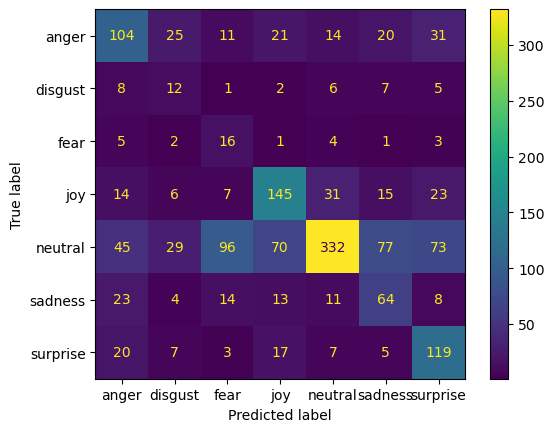

In [17]:
ConfusionMatrixDisplay.from_predictions(preds["labels"], preds["pred"], display_labels=dataset["train"].features["labels"].names)